SCRIPT FUNCTION

Use the red pleth signal to define stimulus events in three stages:
1) Identify events based on when pleth signal crosses a threshold
2) Create epoched data based on these event times
3) Use MNE visual inspection functions to subselect epochs containing actual stim events


In [1]:
#LOAD DATA AND MODULES

#%% Import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import signal
from random import randrange
from numpy import shape as s
import mne
import os
import sys

files = ['patient_gr_wuerzburg_29_11_19.edf']    #just one session

# Load data
os.chdir(r'C:\Users\rhyso\eegdata')
raw = mne.io.read_raw_edf( files[0], preload=True)
# Process data
channels = raw.ch_names
info = raw.info
fs = info['sfreq']
z, t = raw[0:7,:] # EEG
x, t = raw[-2,:] # stim
# extract 50Hz signal
x_ind = range(0,z.shape[1],5) 
x = x[:,x_ind]

Extracting EDF parameters from C:\Users\rhyso\eegdata\patient_gr_wuerzburg_29_11_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9365999  =      0.000 ... 37463.996 secs...


In [2]:
#DEFINE POTENTIAL STIM EVENTS BASED ON WHEN THRESHOLD IS CROSSED.THESE WILL BE CLEANED LATER DURING EPOCH PHASE

plethdata = x[0]
threshold = np.std(plethdata)

#Defines peak based on when pleth signal crosses threshold (peak indicated by peaklogic == 1)
peaklogic = np.empty(len(plethdata), dtype=bool)
peaklogic[:] = np.nan
for i in range(len(plethdata)):
    if i == 0:
        peaklogic[0] = 0
    elif plethdata[i] > threshold and plethdata[i-1] <= threshold:
        peaklogic[i] = 1
    else: 
        peaklogic[i] = 0 

#Identify times when peaks occured
from itertools import compress
peaktimes = list(compress(range(len(peaklogic)), peaklogic))
print('number of events is:' ,len(peaktimes))

#Clean data points peak times which are too close. This will save time when visually inspecting epochs
cleanwidth = -(0.2 * 50) # number of timestamps in 0.2 seconds
new_peaktimes = np.copy(peaktimes)
for i in range (len(peaktimes)):
    if i == 0:
        pass
    elif peaktimes[i-1]-peaktimes[i]<cleanwidth:
        pass
    elif peaktimes[i-1]-peaktimes[i]>=cleanwidth:
        new_peaktimes[i] = new_peaktimes[i-1]

new_peaktimes = np.unique(new_peaktimes)
print('number of events, after cleaning is:' ,len(new_peaktimes))

number of events is: 414
number of events, after cleaning is: 286


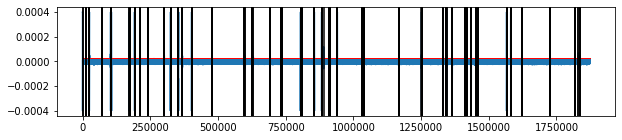

In [13]:
#PLOT STIM EVENTS AGAINST PLETH SIGNAL

#plot peak times in black onto session data 
plt.rcParams["figure.figsize"]= [10, 2]
plt.plot(plethdata) #plot the pleth signal for the whole session
lastindex = len(plethdata)-1
plt.plot([0, lastindex], [threshold, threshold], 'r-', lw=1)    #red line indicates threshold used to define events
for t in new_peaktimes:
    plt.axvline(x=t, color = 'k')
plt.show()

In [3]:
#CREATE AN EVENT ARRAY WHICH IS COMPATIBLE WITH MNE FUNCTIONS

new_peaktimes = np.int_(new_peaktimes)
secondcol = np.zeros(len(new_peaktimes),dtype='int32')   #Length of event (zero in this case)
thirdcol = np.ones(len(new_peaktimes),dtype='int32')     #Label of event type (all the same in this case)
peakevents = np.stack((new_peaktimes,secondcol,thirdcol),axis=-1)
np.shape(peakevents)


(286, 3)

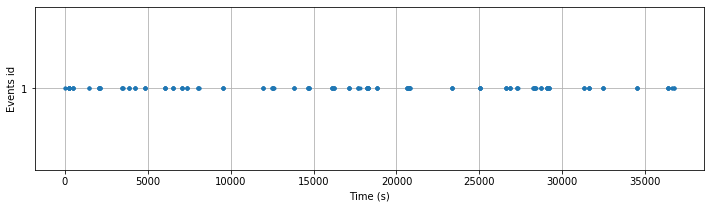

In [15]:
#PLOT STIM EVENTS ON TIME AXIS - USING MNE FUNCTION

fig = plt.rcParams["figure.figsize"]= [12, 3]
fig = mne.viz.plot_events(peakevents, sfreq= 50, first_samp=raw.first_samp)

In [ ]:
#NEED TO RE-ADJUST (50Hz) TO 250Hz RAW SIGNAL
adj250_peakevents = np.copy(peakevents)
for i in range(len(new_peaktimes)):
    adj250_peakevents[i,0] = peakevents[i,0] * 5
print(peakevents[1,:])
print(adj250_peakevents[1,:]) 

In [5]:
#GENERATE EPOCHS

#Create Epochs Around Each Event
epochs = mne.Epochs(raw, adj250_peakevents,tmin=-15,tmax=15) #baseline: 15s before, response: 15s after stim
del raw #delete raw data to free memory
print(epochs)



286 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
<Epochs  |   286 events (good & bad), -15 - 15 sec, baseline [None, 0], ~7 kB, data not loaded,
 '1': 286>


Loading data for 284 events and 7501 original time points ...


<IPython.core.display.Javascript object>


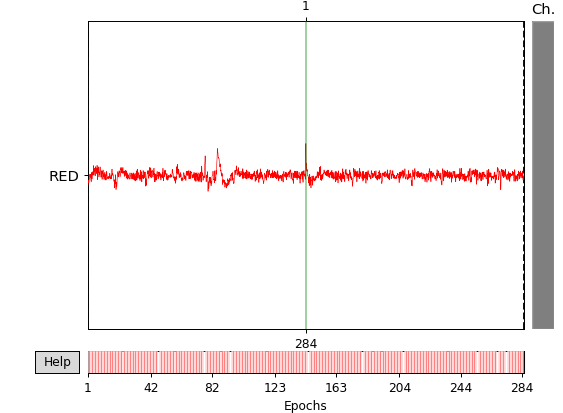

Loading data for 1 events and 7501 original time points ...


<IPython.core.display.Javascript object>


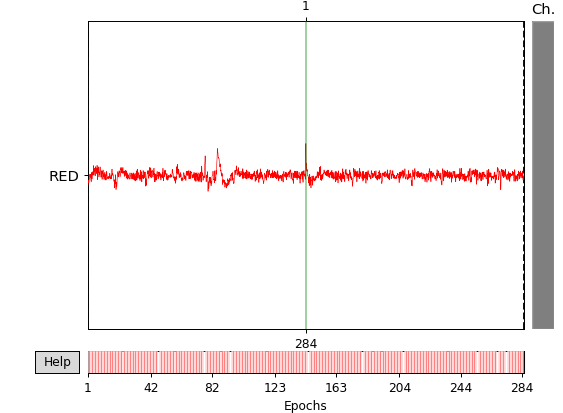

In [11]:
# VISUALLY INSPECT AND CLEAN EPOCHS WITH INTERACTIVE WINDOW

import matplotlib
mne.Epochs.plot(epochs, picks = 'RED', n_epochs = 1, block = True)
#%matplotlib notebook
# bad epochs marked as 'USER' in epochs.drop_log.


In [19]:
np_epochs = mne.Epochs.get_data(epochs)
print('The number of epochs containing actual stim events is ',len(np_epochs))
#epochs.drop_log) '[]' indicates events which contain stim the corresponding epoch

Loading data for 16 events and 7501 original time points ...
The number of epochs containing actual stim events is  16


In [23]:
#Plot a graph of EEG signal over time. Each epoch visualised individually on y axis and avarege displayed separately. 
eeg_epochs = mne.Epochs.pick_channels(epochs,ch_names=['CH1 F7-01','CH2 F8-02','CH3 Fp1-F8','CH4 F8-F7','CH5 Fp1-01','CH6 Fp1-02','CH7 FP1-F7'])
mne.Epochs.plot_image(eeg_epochs, combine='mean')

RuntimeError: By default, MNE does not load data into main memory to conserve resources. adding, dropping, or reordering channels requires epochs data to be loaded. Use preload=True (or string) in the constructor or epochs.load_data().